In [1]:
import pandas as pd
import numpy as np

In [2]:
## result files
# Alexnet -> results_alexnet.csv
# Resnet -> results_resnet.csv

df = pd.read_csv('results_alexnet.csv', index_col=0)
df.head(2)

,class_to_search,filename,top10_search,top10_idx_mejores
0,5,test_sample/c72f067e-5e18-404f-a.png,2|5|5|15|15|6|5|15|15|2|5|10|1|15|10|15|1|1|15...,28795|29092|7819|23218|30009|22100|2469|29824|...
1,9,test_sample/2c475ee6-8b2d-4ee5-b.png,9|9|9|9|9|9|9|9|9|9|9|9|9|9|9|9|9|9|9|9|9|9|9|...,7189|28606|5560|7205|20022|19872|18488|19408|2...


In [3]:
df["top10_search"] = df["top10_search"].str.split('|')
df["top10_idx_mejores"] = df["top10_idx_mejores"].str.split('|')

In [4]:
df.head(2)

,class_to_search,filename,top10_search,top10_idx_mejores
0,5,test_sample/c72f067e-5e18-404f-a.png,"[2, 5, 5, 15, 15, 6, 5, 15, 15, 2, 5, 10, 1, 1...","[28795, 29092, 7819, 23218, 30009, 22100, 2469..."
1,9,test_sample/2c475ee6-8b2d-4ee5-b.png,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...","[7189, 28606, 5560, 7205, 20022, 19872, 18488,..."


In [5]:
# Class mapping to dict
class_mapping = {}

with open('./dataset/mapping.txt', 'r') as fmapping:
    for line in fmapping.readlines():
        line_split = line.replace("\n", "").split("\t")
        class_index = int(line_split[1])
        class_name = line_split[0]
        class_mapping[class_index] = class_name
print(class_mapping)

{0: 'shorts', 1: 'jackets_parka', 2: 'sweater', 3: 'skirts', 4: 'dress', 5: 'blouse_shirts', 6: 'tee', 7: 'pants', 8: 'shoes', 9: 'belt', 10: 'coat', 11: 'scarf', 12: 'bag', 13: 'socks', 14: 'jumper', 15: 'blazer', 16: 'hat', 17: 'glasses', 18: 'tights'}


In [6]:
def overallAP(class_target, candidates, verbose=False):
    # Cast candidates to int by default are string type
    candidates = [int(candidate) for candidate in candidates]

    # Get the GTP (count relevant documents)
    GTP = len([candidate for candidate in candidates if candidate == class_target])

    if verbose:
        print("Total candidates: ", len(candidates))
        print("Total relevant documents: ", GTP)

    if GTP == 0:
        GTP = 1

    count_match_class = 0
    precision_relevant = 0
    for index, candidate in enumerate(candidates):
        if class_target == candidate:
            count_match_class += 1
            precision_relevant += count_match_class / (index + 1)

    return round((1/GTP) * precision_relevant, 2)

# Manual unittest case #1
## class_target = 1
## candidates = [1, 0, 1, 0, 0, 1, 0, 0, 1, 1]

## overallAP(class_target, candidates) # 0.62

# Manual unittest case #2
## class_target = 1
## candidates = [0, 1, 0, 0, 1, 0, 1, 0, 0, 0]

## overallAP(class_target, candidates) # 0.44

In [7]:
all_overall_AP = {}
for (_, row) in df.iterrows():
    if row['class_to_search'] not in all_overall_AP:
        all_overall_AP[row['class_to_search']] = []
    all_overall_AP[row['class_to_search']].append(overallAP(row["class_to_search"], row["top10_search"]))

all_mAP = {}
for index in all_overall_AP.keys():
    all_mAP[index] = round(np.average(all_overall_AP[index]), 4)
# all_mAP

In [8]:
# mAP to table

index_classes = []
class_names = []
mAP_classes = []

for (index, mAP) in all_mAP.items():
    index_classes.append(index)
    class_names.append(class_mapping[index])
    mAP_classes.append(mAP)

df_mAP = pd.DataFrame({
    "Clase": class_names,
    "mAP": mAP_classes
}, columns = ['Clase', 'mAP'], index=index_classes)

df_mAP.sort_index(axis=0)

,Clase,mAP
0,shorts,0.4069
1,jackets_parka,0.1729
2,sweater,0.1535
3,skirts,0.2553
4,dress,0.3114
5,blouse_shirts,0.1477
6,tee,0.2240
7,pants,0.2154
8,shoes,0.4628
9,belt,0.5684


In [9]:
# Get the total mAP
total_mAP = round(df_mAP["mAP"].mean(), 4)
print("Total mAP: ", str(total_mAP))

Total mAP:  0.2684


In [10]:
# Get AP@1 by class

top1 = []
for (_, row) in df.iterrows():
    top1.append((row["class_to_search"], int(row["top10_search"][0])))

top1_classes = {}

for registry in top1:
    target_class = registry[0]
    if target_class not in top1_classes:
        top1_classes[target_class] = []
    top1_classes[target_class].append(1 if target_class == registry[1] else 0)

for index in top1_classes.keys():
    top1_classes[index] = np.average(top1_classes[index])

# top1_classes

In [11]:
# AP@1 to table

index_classes = []
class_names = []
average_precision_at_k_classes = []

for (index, average_precision_at_1) in top1_classes.items():
    index_classes.append(index)
    class_names.append(class_mapping[index])
    average_precision_at_k_classes.append(average_precision_at_1)

df_AP_at_1 = pd.DataFrame({
    "Clase": class_names,
    "AP@1": average_precision_at_k_classes
}, columns = ['Clase', 'AP@1'], index=index_classes)

df_AP_at_1.sort_index(axis=0)

,Clase,AP@1
0,shorts,0.71
1,jackets_parka,0.35
2,sweater,0.39
3,skirts,0.51
4,dress,0.54
5,blouse_shirts,0.30
6,tee,0.47
7,pants,0.71
8,shoes,0.70
9,belt,0.76


In [12]:
# Get the total Precision@1

total_AP_at_1 = round(df_AP_at_1["AP@1"].mean(), 2)
print("Total AP@1: ", str(total_AP_at_1))

Total AP@1:  0.52


In [13]:
from sklearn import metrics

y_true = []
y_pred = []

for row in df.iterrows():
    index_true_class = row[1]["class_to_search"]
    index_pred_class = int(row[1]["top10_search"][0])
    y_true.append(class_mapping[index_true_class])
    y_pred.append(class_mapping[index_pred_class])

print(metrics.classification_report(y_true, y_pred, digits=3))

               precision    recall  f1-score   support

          bag      0.592     0.610     0.601       100
         belt      0.704     0.760     0.731       100
       blazer      0.333     0.380     0.355       100
blouse_shirts      0.242     0.300     0.268       100
         coat      0.429     0.270     0.331       100
        dress      0.505     0.540     0.522       100
      glasses      0.758     0.690     0.723       100
          hat      0.731     0.790     0.760       100
jackets_parka      0.327     0.350     0.338       100
       jumper      0.649     0.610     0.629       100
        pants      0.612     0.710     0.657       100
        scarf      0.521     0.370     0.433       100
        shoes      0.565     0.700     0.625       100
       shorts      0.628     0.710     0.667       100
       skirts      0.510     0.510     0.510       100
        socks      0.446     0.250     0.321       100
      sweater      0.336     0.390     0.361       100
         

In [14]:
def get_key_from_value(dictionary, class_name_target):
    for index, class_name in dictionary.items():
        if class_name == class_name_target:
            return index

y_array_true = []
y_array_pred = []

for y in y_true:
    aux = [0] * len(class_mapping)
    index_class = get_key_from_value(class_mapping, y)
    aux[index_class] = 1
    y_array_true.append(aux)

for y in y_pred:
    aux = [0] * len(class_mapping)
    index_class = get_key_from_value(class_mapping, y)
    aux[index_class] = 1
    y_array_pred.append(aux)


In [15]:
y_array_true = np.array(y_array_true)
y_array_pred = np.array(y_array_pred)

In [16]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(class_mapping)):
    precision[i], recall[i], _ = precision_recall_curve(y_array_true[:, i],
                                                        y_array_pred[:, i])
    average_precision[i] = average_precision_score(y_array_true[:, i], y_array_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_array_true.ravel(),
    y_array_pred.ravel())
average_precision["micro"] = average_precision_score(y_array_true, y_array_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.29


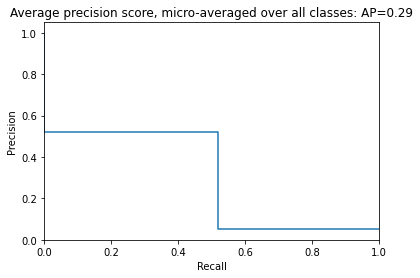

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
plt.show()

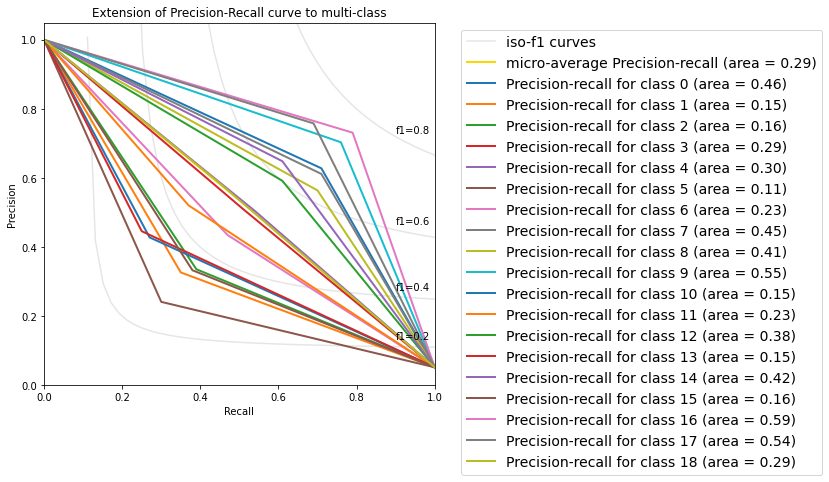

In [18]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i in range(len(class_mapping)):
    l, = plt.plot(recall[i], precision[i], lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.05, 1), prop=dict(size=14))

plt.show()